In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load curve

In [2]:
data_load = pd.read_csv('data/Load_profile_Italy_18.01.22.csv',
    skiprows=3,
    usecols=[0, 2],
    names=['datetime', 'load'],
    dtype={1 : 'float'})
data_load.datetime = pd.to_datetime(data_load.datetime, dayfirst=True)

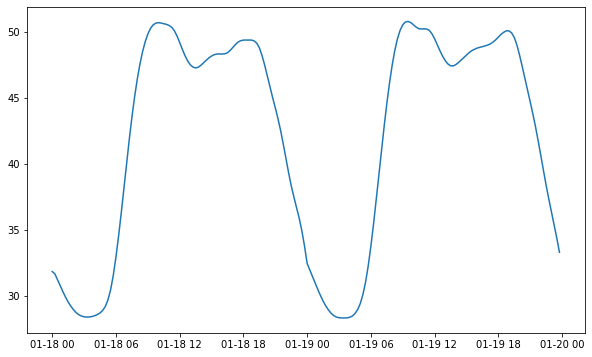

In [3]:
plt.figure(figsize=(10,6))
plt.plot(data_load.datetime, data_load.load)

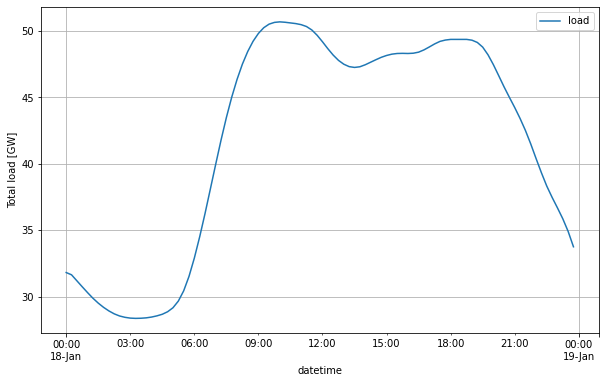

In [4]:
mask = (data_load.datetime >= '2022-01-18 00:00:00') & (data_load.datetime < '2022-01-19 00:00:00')
data_load_day = data_load[mask]
data_load_day.plot('datetime', 'load', figsize=(10,6))
plt.ylabel('Total load [GW]')
plt.grid()

Data are every 15 minutes. We want to have data every 30 minutes

In [6]:
def aggregate_data(df):
    loads = []
    for i in range(1, df.shape[0], 2):
        loads.append(np.mean(df.load[i:i+1]))
    times = np.arange(len(loads))
    return (times, np.array(loads))

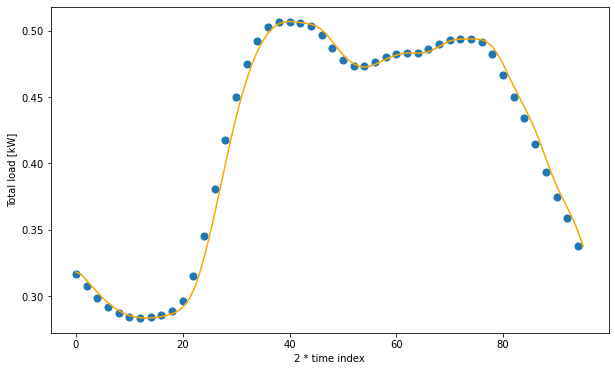

In [7]:
times, agg_data = aggregate_data(data_load_day)
plt.figure(figsize=(10,6))
plt.plot(data_load_day.load / 100, c='orange')
plt.scatter(times*2, agg_data / 100, s=50)
plt.xlabel('2 * time index')
plt.ylabel('Total load [kW]');

In [8]:
agg_df = pd.DataFrame({'time' : times + 1, 'load' : agg_data / 100})
agg_df.to_csv('data/load_agg_data.csv')

 # Photovoltaic power production

In [5]:
sun_df = pd.read_csv('data/Sunny_day.csv', names=['time', 'power'], dtype='float')
cloud_df = pd.read_csv('data/Cloudy_day.csv', names=['time', 'power'], dtype='float')
rain_df = pd.read_csv('data/Rainy_day.csv', names=['time', 'power'], dtype='float')

sun_df.iloc[0] = [0, 0]
cloud_df.iloc[0] = [0, 0]
rain_df.iloc[0] = [0, 0]

In [6]:
from scipy.interpolate import interp1d
sunf = interp1d(sun_df.time, sun_df.power, kind='linear')
cloudf = interp1d(cloud_df.time, cloud_df.power, kind='linear')
rainf = interp1d(rain_df.time, rain_df.power, kind='linear')

factor = 1
x_points = np.arange(0, 24, 0.5)
sunny = sunf(x_points) / factor
cloudy = cloudf(x_points) / factor
rainy = rainf(x_points) / factor

In [16]:
cloudy_simp = sunny / 1.8
rainy_simp = sunny / 15

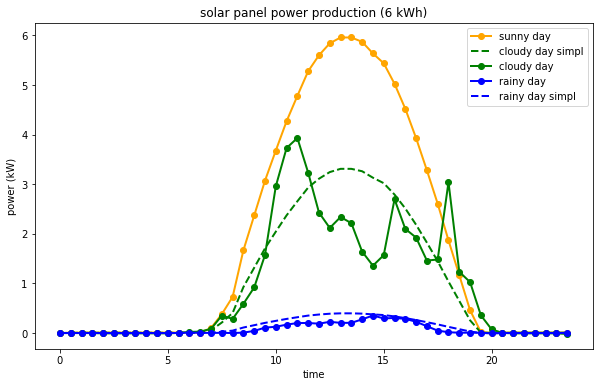

In [17]:
plt.figure(figsize=(10,6))
plt.xlabel('time')
plt.ylabel('power (kW)')
plt.title('solar panel power production (6 kWh)')
plt.plot(x_points, sunny, '-o', c='orange', lw=2, label='sunny day')
plt.plot(x_points, cloudy_simp, c='green', lw=2, ls='dashed', label='cloudy day simpl')
plt.plot(x_points, cloudy, '-o', c='green', lw=2, label='cloudy day')
plt.plot(x_points, rainy, '-o', c='blue', lw=2, label='rainy day')
plt.plot(x_points, rainy_simp, c='blue', lw=2, ls='dashed', label='rainy day simpl')
plt.legend()

In [18]:
panel_df = pd.DataFrame({'time' : x_points, 'sunny' : sunny, 'cloudy' : cloudy_simp, 'rainy' : rainy_simp})
panel_df.to_csv('data/panel_power.csv', sep=',')

# Market prize

In [7]:
pd.read_xml('data/MGP_Prezzi2018120120190101/20181201MGPPrezzi.xml').head()

,id,{http://www.w3.org/2001/XMLSchema}element,Data,Mercato,Ora,PUN,NAT,CNOR,CSUD,NORD,...,GREC,MFTV,PRGP,ROSN,SLOV,SVIZ,BSP,MALT,XAUS,XFRA
0,NewDataSet,NaN,NaN,None,NaN,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,None,NaN,20181201.0,MGP,1.0,"73,900000","73,900000","73,900000","73,900000","73,900000",...,"73,900000","73,900000","73,900000","73,900000","73,900000","73,900000","73,900000","73,900000","73,900000","73,900000"
2,None,NaN,20181201.0,MGP,2.0,"71,980000","71,980000","71,980000","71,980000","71,980000",...,"71,980000","71,980000","71,980000","71,980000","71,980000","71,980000","71,980000","71,980000","71,980000","71,980000"
3,None,NaN,20181201.0,MGP,3.0,"66,880000","66,880000","66,880000","66,880000","66,880000",...,"66,880000","66,880000","66,880000","66,880000","66,880000","66,880000","66,880000","66,880000","66,880000","66,880000"
4,None,NaN,20181201.0,MGP,4.0,"65,560000","65,560000","65,560000","65,560000","65,560000",...,"65,560000","65,560000","65,560000","65,560000","65,560000","65,560000","65,560000","65,560000","65,560000","65,560000"


In [9]:
day_prize = pd.read_xml('data/MGP_Prezzi2018120120190101/20181201MGPPrezzi.xml')[['Data', 'Ora','Mercato', 'PUN']]
day_prize.head()

,Data,Ora,Mercato,PUN
0,NaN,NaN,None,None
1,20181201.0,1.0,MGP,"73,900000"
2,20181201.0,2.0,MGP,"71,980000"
3,20181201.0,3.0,MGP,"66,880000"
4,20181201.0,4.0,MGP,"65,560000"
